# [LLaMA 파생형 모델들](https://velog.io/@srk/Open-source-LLMs-LLaMa-Alpaca-Vicuna-With-PEFT-LoRA)

- `LLaMa` 는 Meta AI 에서 공개한 LLM 이다.
  - `알파카(Alpaca)`, `비큐냐(Vicuna)` 등의 파생형 모델들의 탄생들에 기여
  - 폐쇄형 소스 모델의 적절한 대체재

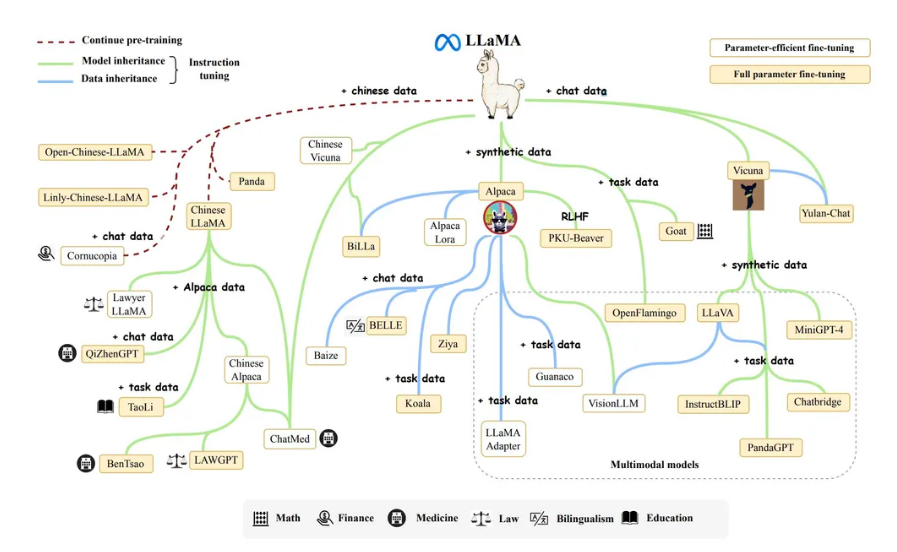

최근 구글의 최대의 경쟁자는 OpenAI가 아닌 오픈소스 AI라고 주장하는 구글 내부 문서가 공개 유출되었다.
- Meta의 LLaMA가 한정적인 researcher들에게 공개된 후, 마치 캄브리아기 대폭발을 연상시키듯 LLaMA를 기반한 오픈소스 AI 모델들이 탄생하고 있기 때문이다.
- 유출된 구글 내부 문건은 Vicuna-13B의 결과를 인용하면서 LLaMA-13B 기반 Vicuna-13B가 구글의 Bard와 거의 차이가 없는 성능 결과를 보이며, 더 작은 비용과 파라미터로 이를 달성하고 있다는 점을 지적하고 있다.

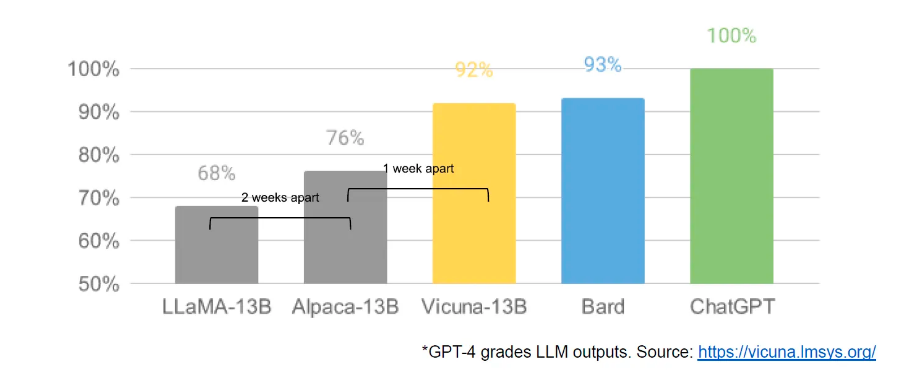

## 각 LLM 실행하기전에 세션 다시 시작

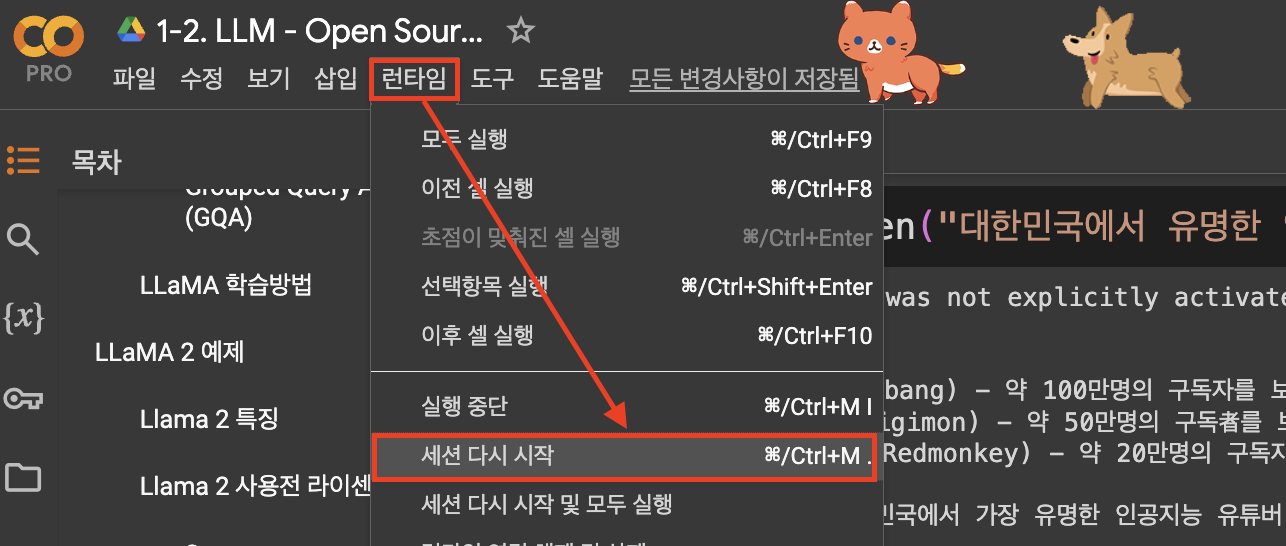

## [Alpaca](https://colab.research.google.com/drive/135ced7oHytdxu3N2DNe1Z0kqjyYIkDXp?usp=sharing#scrollTo=2eSvM9zX_2d3)
- 스탠퍼드 대학의 CRFM (Center for Research Foundation Models)는 학술 연구 목적으로 Meta의 LLaMA-7B 모델을 finetuning한 Alpaca라는 모델을 공개했다.

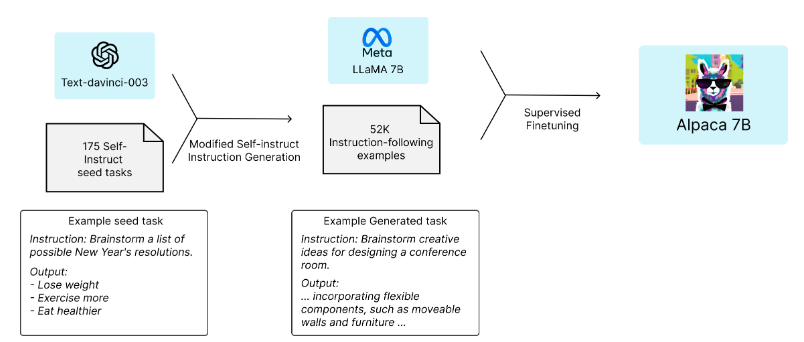

### Setup

In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install triton
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers "trl<0.9.0" peft accelerate bitsandbytes

### Load Model

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-v0.3-bnb-4bit",      # New Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",           # Llama-3 15 trillion tokens model 2x faster!
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/llama-3-70b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",        # Phi-3 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",             # Gemma 2.2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.0+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.27.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


### Load Dataset

In [ ]:
alpaca_prompt = """
  Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

  ### Instruction:
  {}

  ### Input:
  {}

  ### Response:
  {}
"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("yahma/alpaca-cleaned", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

Generating train split:   0%|          | 0/51760 [00:00<?, ? examples/s]

Map:   0%|          | 0/51760 [00:00<?, ? examples/s]

### Train the model
- [SFTTrainer docs](https://huggingface.co/docs/trl/sft_trainer)

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map (num_proc=2):   0%|          | 0/51760 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.168 GB.
5.613 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 51,760 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,1.815500
2,2.287800
3,1.705600
4,2.022100
5,1.710300
6,1.660400
7,1.186300
8,1.271000
9,1.130100
10,1.189700


In [ ]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

221.046 seconds used for training.
3.68 minutes used for training.
Peak reserved memory = 6.842 GB.
Peak reserved memory for training = 1.229 GB.
Peak reserved memory % of max memory = 30.864 %.
Peak reserved memory for training % of max memory = 5.544 %.


### Inference
- Let's run the model! You can change the instruction and input - leave the output blank!

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

['<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nContinue the fibonnaci sequence.\n\n### Input:\n1, 1, 2, 3, 5, 8\n\n### Response:\n13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025']

- You can also use a TextStreamer for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Continue the fibonnaci sequence.

### Input:
1, 1, 2, 3, 5, 8

### Response:
11, 18, 29, 47, 76, 123<|end_of_text|>


## [Vicuna](https://colab.research.google.com/github/camenduru/text-generation-webui-colab/blob/main/vicuna-13b-GPTQ-4bit-128g.ipynb)
- Vicuna-13B 는 Meta의 LLaMA와 Stanford의 Alpaca에 영감을 받아 UC Berkeley, UCSD, CMU, MBZUAI(Mohamed Bin Zayed Univ. of AI)가 공동으로 개발한 오픈소스 챗봇으로 ShardGPT로 부터 수집된 사용자들의 대화로 LLaMA를 fine-tuning한 모델이다.

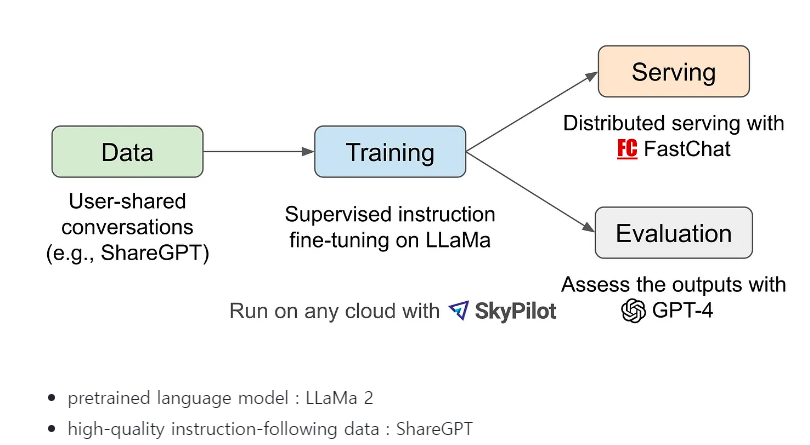

### Install

In [ ]:
%cd /content
!apt-get -y install -qq aria2

!git clone -b v2.5 https://github.com/camenduru/text-generation-webui
%cd /content/text-generation-webui
!pip install -q -r requirements.txt

/content
Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 123595 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.18.1-1ubuntu0.22.04.3_amd64.deb ...
Unpacking libc-ares2:amd64 (1.18.1-1ubuntu0.22.04.3) ...
Selecting previously unselected package libaria2-0:amd64.
Preparing to unpack .../libaria2-0_1.36.0-1_amd64.deb ...
Unpacking libaria2-0:amd64 (1.36.0-1) ...
Selecting previously unselected package aria2.
Preparing to unpack .../aria2_1.36.0-1_amd64.deb ...
Unpacking aria2 (1.36.0-1) ...
Setting up libc-ares2:amd64 (1.18.1-1ubuntu0.22.04.3) ...
Setting up libaria2-0:amd64 (1.36.0-1) ...
Setting up aria2 (1.36.0-1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.4) ...
/sbin/ldconfig.real: /usr/local/lib/libur_adapter_opencl.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmal

### download model

In [ ]:
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/4bit/vicuna-13b-GPTQ-4bit-128g/raw/main/config.json -d /content/text-generation-webui/models/vicuna-13b-GPTQ-4bit-128g -o config.json
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/4bit/vicuna-13b-GPTQ-4bit-128g/raw/main/generation_config.json -d /content/text-generation-webui/models/vicuna-13b-GPTQ-4bit-128g -o generation_config.json
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/4bit/vicuna-13b-GPTQ-4bit-128g/raw/main/special_tokens_map.json -d /content/text-generation-webui/models/vicuna-13b-GPTQ-4bit-128g -o special_tokens_map.json
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/4bit/vicuna-13b-GPTQ-4bit-128g/resolve/main/tokenizer.model -d /content/text-generation-webui/models/vicuna-13b-GPTQ-4bit-128g -o tokenizer.model
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/4bit/vicuna-13b-GPTQ-4bit-128g/raw/main/tokenizer_config.json -d /content/text-generation-webui/models/vicuna-13b-GPTQ-4bit-128g -o tokenizer_config.json
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/4bit/vicuna-13b-GPTQ-4bit-128g/resolve/main/vicuna-13b-4bit-128g.safetensors -d /content/text-generation-webui/models/vicuna-13b-GPTQ-4bit-128g -o vicuna-13b-4bit-128g.safetensors



Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
7ad847|OK  |    41KiB/s|/content/text-generation-webui/models/vicuna-13b-GPTQ-4bit-128g/config.json

Status Legend:
(OK):download completed.

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
eccad0|OK  |     343B/s|/content/text-generation-webui/models/vicuna-13b-GPTQ-4bit-128g/generation_config.json

Status Legend:
(OK):download completed.

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
37f82e|OK  |    66KiB/s|/content/text-generation-webui/models/vicuna-13b-GPTQ-4bit-128g/special_tokens_map.json

Status Legend:
(OK):download completed.

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
c55e47|OK  |   569KiB/s|/c

### run inference server

In [ ]:
!echo "dark_theme: true" > /content/settings.yaml
!echo "chat_style: wpp" >> /content/settings.yaml

%cd /content/text-generation-webui
!python server.py --share --settings /content/settings.yaml --wbits 4 --groupsize 128 --loader AutoGPTQ --model /content/text-generation-webui/models/vicuna-13b-GPTQ-4bit-128g


/content/text-generation-webui
2024-08-30 08:05:11 WARNING:The gradio "share link" feature uses a proprietary executable to create a reverse tunnel. Use it with care.
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
2024-08-30 08:05:15.203261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 08:05:15.223796: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 08:05:15.230265: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register fact

### 접속: public URL

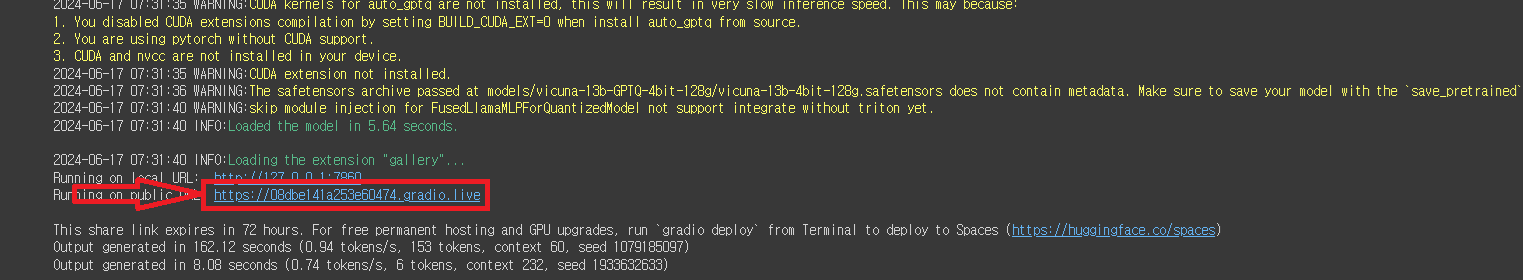

### Generate

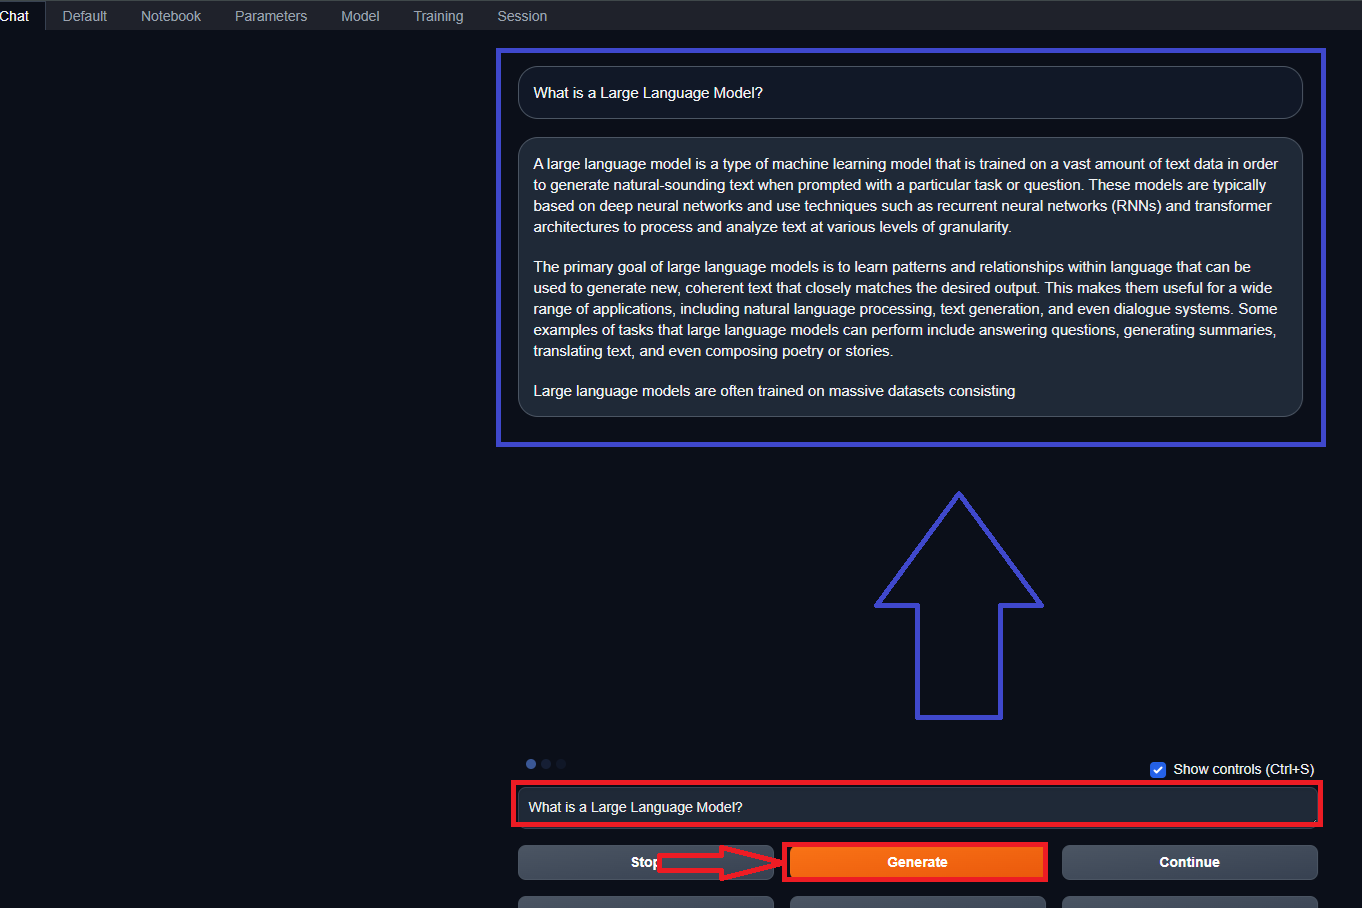

# 한국어 OpenSource LLM

## [KULLM(Korea University Large Language Model)](https://github.com/nlpai-lab/KULLM)
- 고려대학교 NLP & AI 연구실과 HIAI연구소
- `데이터셋`: 150만 개의 한국어 데이터셋
  - GPT4-LLM, Dolly, ShareGPT를 DeepL로 번역
- `미세조정(Fine-Tuning)`: ployglot-Ko 모델을 기반 LoRA를 사용하여 학습(KU LLM모델 구축)
  - PEFT 라이브러리 사용(LoRA)

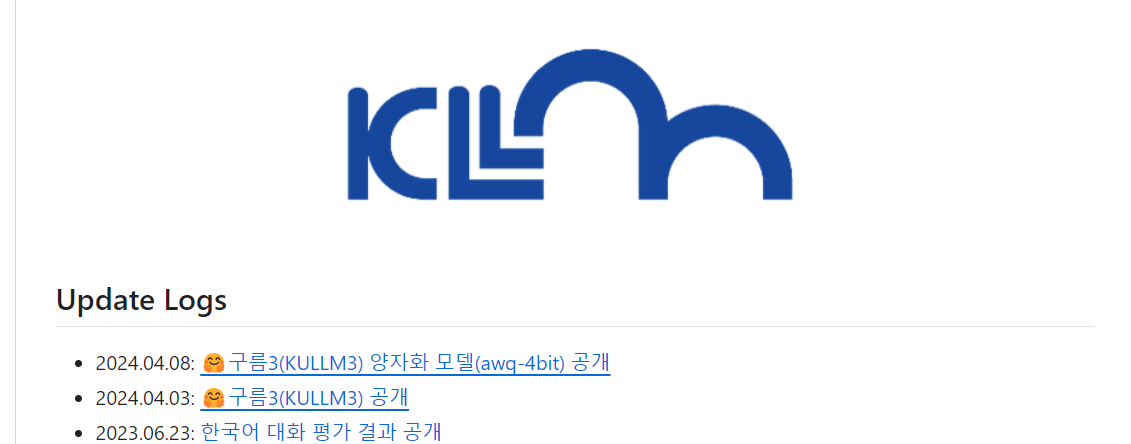

### KULLM3 대화 성능 평가 결과

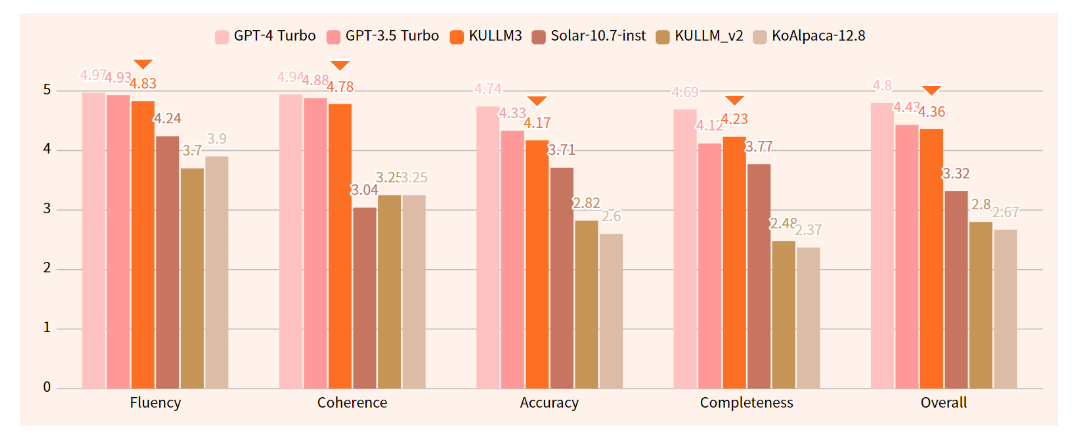

### Install

In [ ]:
!pip install torch transformers==4.38.2 accelerate

### download model

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer

MODEL_DIR = "nlpai-lab/KULLM3"
model = AutoModelForCausalLM.from_pretrained(MODEL_DIR, torch_dtype=torch.float16).to("cuda")
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.60k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

### Inference

In [ ]:
s = "고려대학교에 대해서 알고 있니?"
conversation = [{'role': 'user', 'content': s}]
inputs = tokenizer.apply_chat_template(
    conversation,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors='pt').to("cuda")
_ = model.generate(inputs, streamer=streamer, max_new_tokens=1024, use_cache=True)

네, 고려대학교에 대해 알고 있습니다. 고려대학교는 대한민국 서울에 위치한 사립 대학교로, 1905년에 설립되었습니다. 이 대학교는 한국에서 가장 오래된 대학 중 하나로, 다양한 학부 및 대학원 프로그램을 제공합니다. 고려대학교는 특히 법학, 경제학, 정치학, 사회학, 문학, 과학 분야에서 높은 명성을 가지고 있습니다. 또한, 스포츠 분야에서도 활발한 활동을 보이며, 대한민국 대학 스포츠에서 중요한 역할을 하고 있습니다. 고려대학교는 국제적인 교류와 협력에도 적극적이며, 전 세계 다양한 대학과의 협력을 통해 글로벌 경쟁력을 강화하고 있습니다.


## [KoAlpaca](https://github.com/Beomi/KoAlpaca)
- `데이터셋`: AIpaca 데이터셋의 지시어를 DeepL로 번역 후, GPT-3.5 turbo를 사용해 한국어 생성
- `미세조정(Fine-Tuning)`: LLaMA와 ployglot-Ko 모델을 기반으로 학습

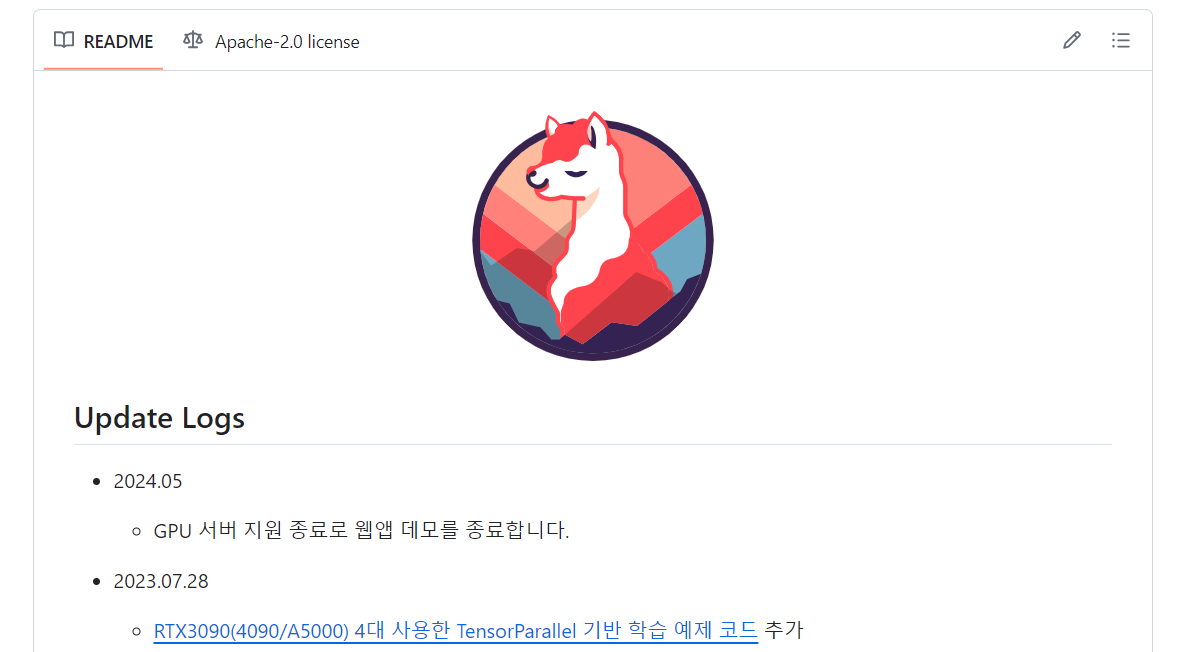

### 완성된 모델: 한국어 기반 모델(Polyglot-ko) & 영한 모델(LLAMA)
- KoAlpaca는 백본 모델로 한국어 모델은 Polyglot-ko(5.8B)모델을, 영문+한국어 기반 모델은 LLAMA를 사용하였습니다.
- Meta의 LLAMA 모델은 한국어 데이터셋을 충분히 학습하지 않아서, 실제 Inference를 돌려보았을 때 한국어 성능이 낮게 나오는 이슈가 있습니다.
- 보다 한국어에 나은 퀄리티를 얻어보고자 Polyglot-ko 5.8B, 12.8B 모델을 백본으로 사용한 모델도 학습시켰습니다.

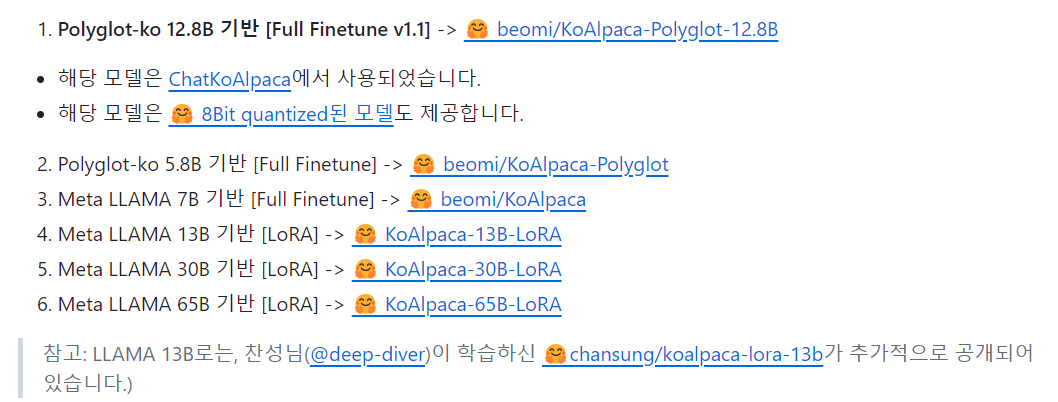

### Install

In [ ]:
!pip install -U torch transformers tokenizers accelerate safetensors

  Using cached tokenizers-0.20.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)


### download model

In [ ]:
import torch
from transformers import pipeline, AutoModelForCausalLM

MODEL = 'beomi/KoAlpaca-Polyglot-5.8B'

model = AutoModelForCausalLM.from_pretrained(
    MODEL,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
).to(device=f"cuda", non_blocking=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/36.8k [00:00<?, ?B/s]

model-00001-of-00013.safetensors:   0%|          | 0.00/926M [00:00<?, ?B/s]

model-00002-of-00013.safetensors:   0%|          | 0.00/952M [00:00<?, ?B/s]

model-00003-of-00013.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00004-of-00013.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00005-of-00013.safetensors:   0%|          | 0.00/952M [00:00<?, ?B/s]

model-00006-of-00013.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00007-of-00013.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00008-of-00013.safetensors:   0%|          | 0.00/952M [00:00<?, ?B/s]

model-00009-of-00013.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00010-of-00013.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00011-of-00013.safetensors:   0%|          | 0.00/952M [00:00<?, ?B/s]

model-00012-of-00013.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00013-of-00013.safetensors:   0%|          | 0.00/515M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/13 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(30080, 4096)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-27): 28 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXSdpaAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=4096, out_features=12288, bias=True)
          (dense): Linear(in_features=4096, out_features=4096, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=4096, out_features=16384, bias=True)
          (dense_4h_to_h): Linear(in_features=16384, out_features=4096, bias=T

### Inference

In [ ]:
pipe = pipeline(
    'text-generation',
    model=model,
    tokenizer=MODEL,
    device=0
)

def ask(x, context='', is_input_full=False):
    ans = pipe(
        f"### 질문: {x}\n\n### 맥락: {context}\n\n### 답변:" if context else f"### 질문: {x}\n\n### 답변:",
        do_sample=True,
        max_new_tokens=512,
        temperature=0.7,
        top_p=0.9,
        return_full_text=False,
        eos_token_id=2,
    )
    print(ans[0]['generated_text'])

ask("딥러닝이 뭐야?")

tokenizer_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

딥러닝은 인공신경망을 통해 더 복잡한 문제를 해결하는 기술입니다. 기계가 데이터를 보고 자동으로 패턴을 학습하며, 데이터를 기반으로 패턴을 예측하는 능력을 갖습니다. 이를 통해 의료 진단, 금융 분석, 자연어 처리 등 다양한 분야에서 활용됩니다. 구글, 아마존, 페이스북 등에서 사용되며, 인공지능 분야에서 가장 발전된 기술 중 하나입니다. 
